In [1]:
# Jade Chongsathapornpong, June 2023
import matplotlib.pyplot as plt
import numpy as np
%matplotlib nbagg
import fabio
import pyFAI
import pyFAI.azimuthalIntegrator
import pyFAI.calibrant
import pyFAI.gui.jupyter

## Predicted calibration image
We'd like to produce, given an estimated detector geometry and known calibrant powder, a prediction of where diffraction rings will appear. This is the inverse of what pyFAI usually does, and is much easier in principle. 

First, we'll define an azimuthal integrator. Instead of using the geometry reference produced by pyFAI calibration, we'll insert our own. The coordinates are explained in the [documentation](https://www.silx.org/doc/pyFAI/latest/geometry.html) here.

In [2]:
# All distances in m, rotations in radians
D = 0.1 # from sample to detector *plane*, orthogonal distance
p1 = 0.1 # point of normal incidence with detector along detector dimension 1
p2 = 0.1 # "" dimension 2
r1 = 0
r2 = 0
r3 = 0
l = 1e-10
pilatus = pyFAI.detector_factory("Pilatus1M")

ai = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(dist=D, poni1=p1, poni2=p2, rot1=r1, rot2=r2, rot3=r3, 
                                                   detector=pilatus, wavelength=l)

Next, we need to define a calibrant compound. This is a bit complicated and I don't quite understand it, so I'll wait for Isabelle/Mauro. For now, we'll assume it's one of the known calibrants.

In [3]:
LaB6 = pyFAI.calibrant.CALIBRANT_FACTORY("LaB6")
LaB6.wavelength = l
AgBh = pyFAI.calibrant.CALIBRANT_FACTORY("AgBh")
AgBh.wavelength = l

As we can see, what the detector will see of the pattern is now visible. 

<IPython.core.display.Javascript object>


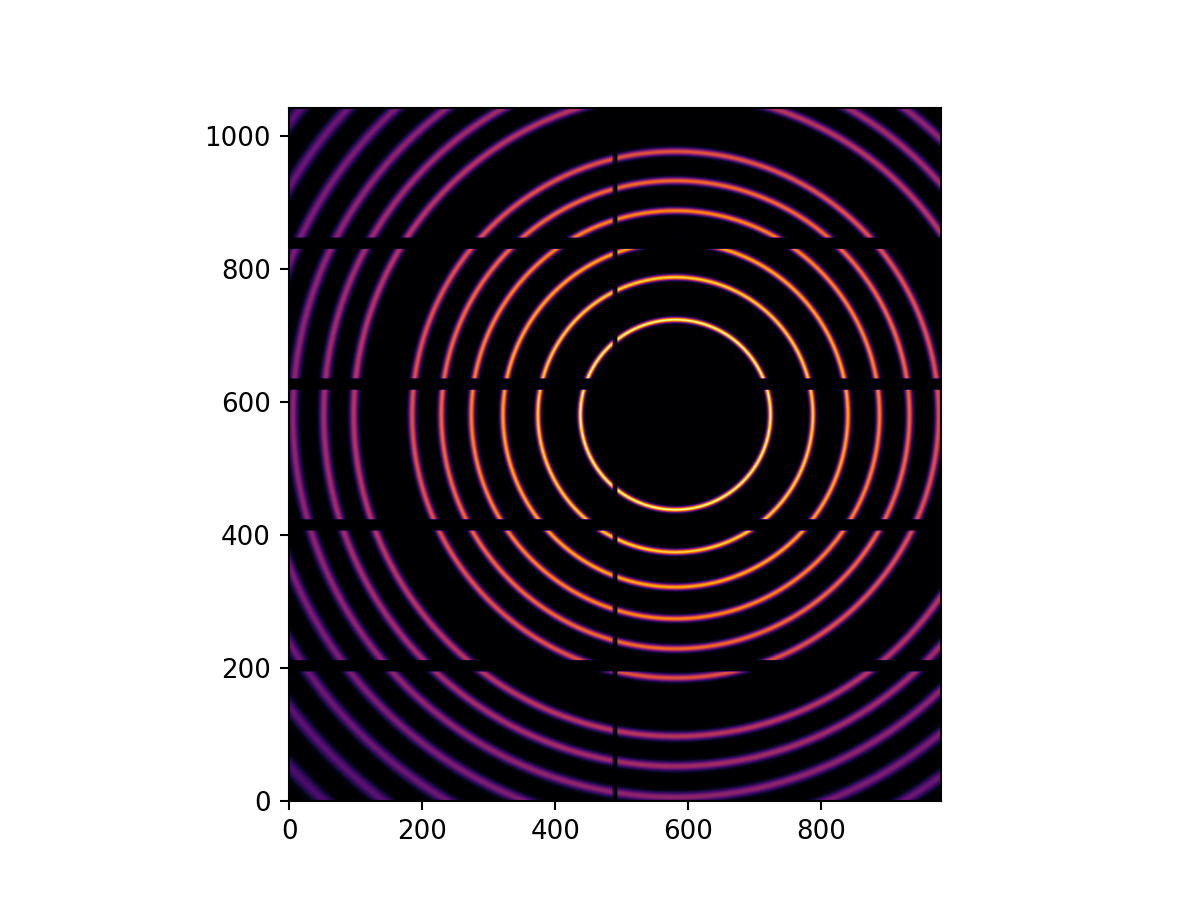

In [5]:
imageLaB6 = LaB6.fake_calibration_image(ai)
imageAgBh = AgBh.fake_calibration_image(ai)
_ = pyFAI.gui.jupyter.display(imageLaB6) # Be sure to stop interactivity in this cell before moving to the next ones!

### Superimposing images
Since our goal is informing detector placement, we might want to superimpose two different patterns. Unfortunately, this isn't built-in to pyFAI.gui. Ideally I'd generate two images with different colormaps and superimpose them, but instead I'll manipulate the images directly into different color channels.

In [6]:
# I'll put LaB6 into the red channel, AgBh into green, and zeros into blue
iLaB6 = np.expand_dims(imageLaB6, 0)
iAgBh = np.expand_dims(imageAgBh, 0)
empty = np.zeros(iLaB6.shape)
colorimage = np.vstack((iLaB6, iAgBh, empty)).transpose((1,2,0))
colorimage.shape # (1043 px x 981 px x 3 channels)

(1043, 981, 3)

<IPython.core.display.Javascript object>


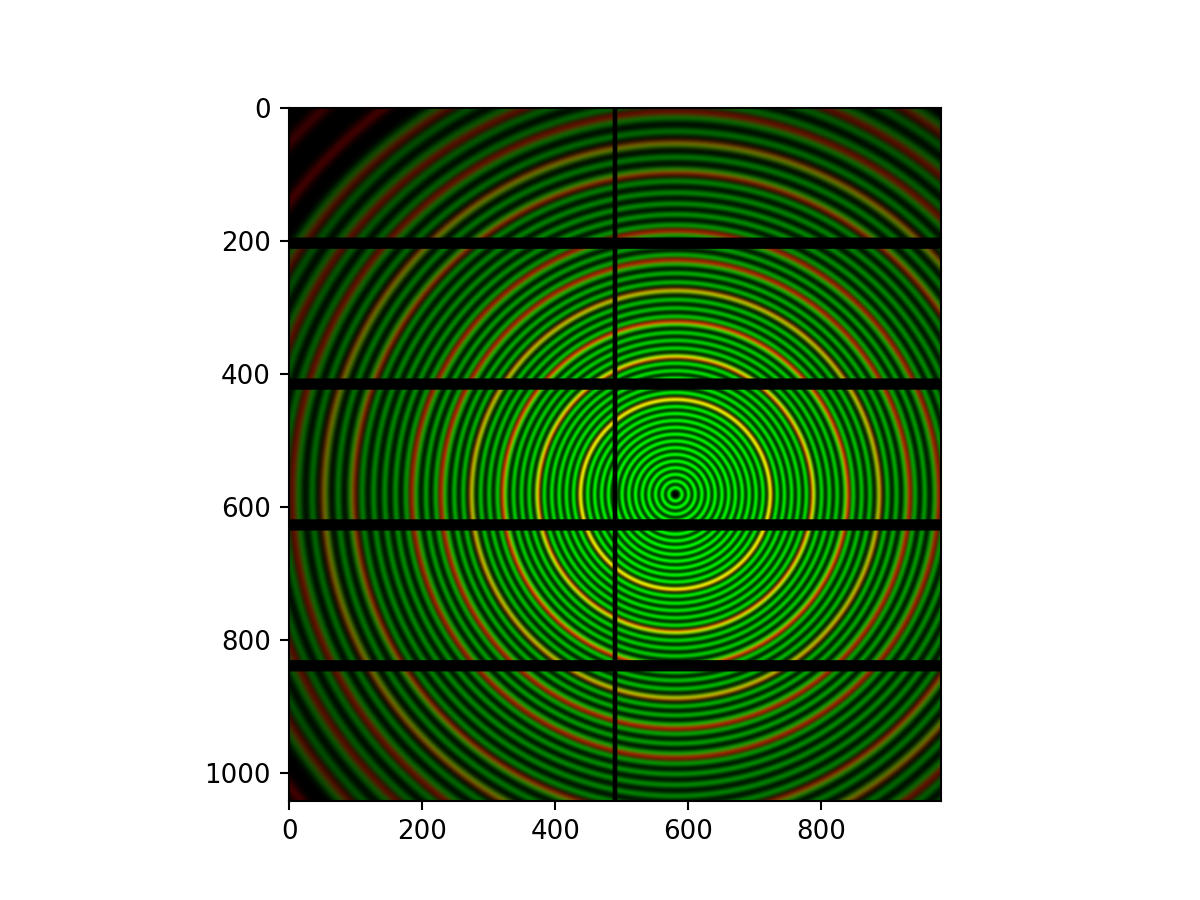

In [7]:
plt.imshow(colorimage)